# Sarcasm Detector

Sarcasm Detector — Headline-level Fake News Classifier

This notebook demonstrates an end-to-end approach for detecting sarcastic or misleading news headlines using a public headlines dataset. The goal is to build a robust baseline classifier and compare several approaches with increasing modeling complexity: classical TF‑IDF features with Logistic Regression, FastText embeddings averaged into document vectors, a simple BiGRU network, and a Transformer (BERT) fine-tuning pipeline.

In [ ]:
from IPython.display import display
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Load and clean

In [2]:
# Load the dataset
df = pd.read_json('./SarcasmDetect.json', lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [3]:
df.info()

print('\n==============\nDataFrame shape:')
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB

DataFrame shape:
(28619, 3)


In [ ]:
# Check for duplicates
display(df.value_counts())
df.drop_duplicates(inplace=True)
#df.value_counts()

is_sarcastic  headline                                                                                                    article_link                                                                                                                    
0             hillary clinton vs. herself                                                                                 https://www.huffingtonpost.comhttp://nymag.com/daily/intelligencer/2016/05/hillary-clinton-candidacy.html                           2
1             nation not sure how many ex-trump staffers it can safely reabsorb                                           https://politics.theonion.com/nation-not-sure-how-many-ex-trump-staffers-it-can-safel-1823468346                                    2
0             "eco-warrior" vandana shiva, at $40,000 a speech, rejoins hawaii anti-gmo crusade, but truth is the victim  https://www.huffingtonpost.com/entry/ecowarrior-vandana-shiva-_b_6528032.html                                      

In [ ]:
# Check empty headlines
df[df['headline'] == '']

,is_sarcastic,headline,article_link


In [6]:
df['headline'] = df['headline'].map(lambda x: x.strip() if isinstance(x, str) else x)
df['headline'].value_counts()

headline
'no way to prevent this,' says only nation where this regularly happens            12
the 20 funniest tweets from women this week                                        10
sunday roundup                                                                     10
the funniest tweets from parents this week                                          6
the funniest tweets from women this week                                            4
                                                                                   ..
man lived alongside dead father's body for four months                              1
obama family adopts 44-year-old portuguese water man                                1
we need to treat gun violence like a public health problem                          1
e3 organizers cancel convention after discovering immersive power of literature     1
dad clarifies this not a food stop                                                  1
Name: count, Length: 28503, dtype: int64

In [7]:
# add new column with count of each headline
df['headline_count'] = df.groupby('headline')['headline'].transform('count')
df['headline_count'].value_counts()

headline_count
1     28424
2       144
10       20
12       12
4         8
6         6
3         3
Name: count, dtype: int64

In [8]:
df[df['headline_count']>=2].groupby(['headline','is_sarcastic']).size()#.reset_index(name='count').sort_values(by='count', ascending=False)

headline                                                                 is_sarcastic
'no way to prevent this,' says only nation where this regularly happens  1               12
5 things everyone gets wrong about napping                               0                2
all y'all urged to go fuck yo' selves                                    1                2
antarctic observational comic running out of ideas                       1                2
area man busts his ass all day, and for what?                            1                2
                                                                                         ..
will smith: the black man everyone at work can agree on                  1                2
willow rented                                                            1                2
wolf pack fails to raise orphaned infant                                 1                2
woman injured in hostile makeover                                        1            

In [9]:
# Check conflicting: if the same headline has both sarcastic and non-sarcastic labels
conflicting_headlines = df.groupby('headline')['is_sarcastic'].nunique()

# Filter for headlines that have more than one unique value in 'is_sarcastic'
conflicting_headlines = conflicting_headlines[conflicting_headlines > 1].index.tolist()

if conflicting_headlines:
    print(f"Conflicting headlines found: {len(conflicting_headlines)}")
    for headline in conflicting_headlines:
        print(headline)
else:
    print("No conflicting headlines found.")

No conflicting headlines found.


In [10]:
df.drop_duplicates(subset=['headline', 'is_sarcastic'], inplace=True)
df.shape

(28503, 4)

In [11]:
df['is_sarcastic'].value_counts()

is_sarcastic
0    14951
1    13552
Name: count, dtype: int64

In [12]:
df.columns

Index(['is_sarcastic', 'headline', 'article_link', 'headline_count'], dtype='object')

In [13]:
df.drop(['headline_count', 'article_link', 'headline_count'], axis=1, inplace=True)

In [14]:
df.columns

Index(['is_sarcastic', 'headline'], dtype='object')

# Train test split

In [ ]:
# Train test split
X = df['headline']
y = df['is_sarcastic']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)

# Clean and normalize texts

## Functions for text normalization

In [103]:
import re
from bs4 import BeautifulSoup
import unicodedata
import contractions
import spacy
import nltk
import tqdm # for nice progressbar

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

# python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm') # not installed

# HTML removal
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

# accent removal
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

# contraction expansion
def expand_contractions(text):
    return contractions.fix(text)

# lemamtization
def spacy_lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

# special character removal
def remove_special_characters(text, remove_digits=False, exclude='\"\'-.!?'):
    # Build regex pattern dynamically to exclude specified characters
    exclude_escaped = re.escape(exclude)
    if not remove_digits:
        pattern = rf'[^a-zA-Z0-9\s{exclude_escaped}]'
    else:
        pattern = rf'[^a-zA-Z\s{exclude_escaped}]'
    return re.sub(pattern, '', text)

# stopword removal
def remove_stopwords(text, stopwords=None):
    if not stopwords:
        stopwords = nltk.corpus.stopwords.words('english')
    tokens = nltk.word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

def remove_zero_width_spaces(text):
    # Remove zero-width space characters (U+200B) combined with words
    return text.replace('\u200b', '')

def uniform_hyphens(text):
    """
    Replace all types of hyphens/dashes in the text with a standard ASCII hyphen '-'.
    Handles: hyphen-minus, en dash, em dash, figure dash, horizontal bar, etc.
    """
    # Unicode dashes: \u2010-\u2015, \u2212, \u2043, \uFE58, \uFE63, \uFF0D
    dash_pattern = re.compile(r'[\u2010\u2011\u2012\u2013\u2014\u2015\u2212\u2043\uFE58\uFE63\uFF0D]')
    # Replace all with ASCII hyphen-minus
    text = dash_pattern.sub('-', text)
    return text

def add_spaces_around_special_chars(text):
    # Define the set of special characters you want to target
    special_chars = r'\.\,\!\?\(\)\[\]\{\}\-\"\':;$%#&'
    # Add spaces around each special character
    return re.sub(f'([{special_chars}])', r' \1 ', text)

def text_pre_processor(text, zero_width_spaces_removal=True, html_strip=True,  
                       accented_char_removal=True, contraction_expansion=True,
                       text_lower_case=True, text_lemmatization=True,
                       special_char_removal=True, exclude_chars='\'\"-{}<>', remove_digits=True, 
                       stopword_removal=True,
                       stopword_list=None):
    """
    lemmatization is slow
    """
    # remove zero-width spaces
    if zero_width_spaces_removal:
        text = remove_zero_width_spaces(text)

    # strip HTML
    if html_strip:
        text = strip_html_tags(text)

    # remove accented characters
    if accented_char_removal:
        text = remove_accented_chars(text)

    # expand contractions
    if contraction_expansion:
        text = expand_contractions(text)

    # lowercase the text
    if text_lower_case:
        text = text.lower()

    # lemmatize text
    if text_lemmatization:
        text = spacy_lemmatize_text(text)

    # remove special characters and\or digits
    if special_char_removal:
        # insert spaces between special characters to isolate them
        special_char_pattern = re.compile(r'([{.(-)!}])') # 'I will not go!here' => I will not go ! here'
        text = special_char_pattern.sub(" \\1 ", text)
        text = remove_special_characters(text, remove_digits=remove_digits, exclude=exclude_chars)
        # I will not go!here => I will not gohere
        # I will not go ! here' => I will not go  here

    # remove stopwords
    if stopword_removal:
        text = remove_stopwords(text, stopwords=stopword_list)
        
    # remove extra newlines (often might be present in really noisy text)
    text = text.translate(text.maketrans("\n\t\r", "   "))
    # remove extra whitespace
    text = re.sub(' +', ' ', text) # 'I   will  not' => 'I will not'
    text = text.strip()

    return text

def text_pre_processor_1(text):
    """
    Pre-process a single text document.
    It is similar to the UnicodeTokenizer of TensorFlow!
    """
    text = remove_zero_width_spaces(text)
    text = uniform_hyphens(text)
    text = strip_html_tags(text)
    text = remove_accented_chars(text)
    text = expand_contractions(text)
    
    # Collapse repeated hyphens (including those separated by spaces) to a single hyphen
    text = re.sub(r'(-\s*){2,}', '-', text)
    # Collapse repeated apostrophes (including those separated by spaces) to a single apostrophe
    text = re.sub(r"('\s*){2,}", "'", text)

    text = add_spaces_around_special_chars(text)  # add spaces around special characters
    text = text.lower()  # lowercase the text

    # remove extra whitespace
    text = re.sub(' +', ' ', text) # 'I   will  not' => 'I will not'
    text = text.strip()

    return text

def corpus_pre_processor(corpus, **kwargs):
    norm_corpus = []
    for doc in tqdm.tqdm(corpus):
        norm_corpus.append(text_pre_processor(doc, **kwargs))
    return norm_corpus

def corpus_pre_processor_1(corpus, **kwargs):
    norm_corpus = []
    for doc in tqdm.tqdm(corpus):
        norm_corpus.append(text_pre_processor_1(doc))
    return norm_corpus

[nltk_data] Downloading package punkt to /Users/jianhuixu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/jianhuixu/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jianhuixu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
print(remove_non_english("This is English. 这是中文。", placeholder='<FOREIGN>'))
print(remove_non_english("¯\\_(ツ)_/¯", placeholder='<FOREIGN>'))  # Output: <FOREIGN>
print(remove_non_english("© 2024", placeholder='<FOREIGN>'))      # Output: <FOREIGN> 2024

In [104]:
import unicodedata
import re

def find_special_nonenglish_accented_words(texts):
    """
    Returns four lists of (line_number, word, text) tuples for words in the raw texts that contain:
    - Special characters (not a-z, A-Z, 0-9, or space)
    - Non-ASCII (non-English) characters
    - Accented characters
    - Non-Unicode (words that cannot be encoded in Unicode)
    """
    special_char_pattern = re.compile(r'[^a-zA-Z0-9\s]')
    non_ascii_pattern = re.compile(r'[^\x00-\x7F]')
    accented_pattern = re.compile(r'[\u00C0-\u017F]')  # Latin accented range

    special_words = []
    non_english_words = []
    accented_words = []
    non_unicode_words = []

    for idx, text in enumerate(texts):
        words = str(text).split()
        for word in words:
            if special_char_pattern.search(word):
                special_words.append((idx, word, text))
            if non_ascii_pattern.search(word):
                non_english_words.append((idx, word, text))
            if accented_pattern.search(word):
                accented_words.append((idx, word, text))
            try:
                word.encode('utf-8')
            except UnicodeEncodeError:
                non_unicode_words.append((idx, word, text))
    return special_words, non_english_words, accented_words, non_unicode_words

#special_words, non_english_words, accented_words = find_special_nonenglish_accented_words(X)
special_words, non_english_words, accented_words, non_unicode_words = find_special_nonenglish_accented_words(corpus_pre_processor_1(X))

  0%|          | 0/28503 [00:00<?, ?it/s]/var/folders/qt/8nh0yrjj4q5dvgzzdm8s9j_40000gn/T/ipykernel_4246/3951685545.py:18: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
100%|██████████| 28503/28503 [00:00<00:00, 31604.29it/s]


In [107]:
X.iloc[105]

'my worst audition ever?  or, the danger of playing paddle ball, chewing gum, and singing "we built this city" simultaneously'

In [105]:
pd.DataFrame(special_words, columns=["line_number", "word", "text"])

,line_number,word,text
0,1,.,dem rep . totally nails why congress is fallin...
1,1,",",dem rep . totally nails why congress is fallin...
2,2,:,eat your veggies : 9 deliciously different rec...
3,4,',mother comes pretty close to using word ' stre...
4,4,',mother comes pretty close to using word ' stre...
...,...,...,...
29111,28493,-,bakery owner vows to stop making wedding cakes...
29112,28496,',polish rapper under fire for use of the word '...
29113,28496,',polish rapper under fire for use of the word '...
29114,28497,',how san antonio ' s dominant defense is fuelin...


In [108]:
pd.DataFrame(non_english_words, columns=["line_number", "word", "text"])

,line_number,word,text


In [109]:
pd.DataFrame(accented_words, columns=["line_number", "word", "text"])

,line_number,word,text


## Check text preprocessors and their effects on LR

* Removing stop words strongly degrades on model performance
* Romoving contraction slightly improve it by 0.01 in acc
* Lemmatization is very slow

### Quick look at the preprocessed text

In [ ]:
%%time
# Lemmatization is slow
norm_train = corpus_pre_processor(X_train, remove_digits=False)
norm_test = corpus_pre_processor(X_test, remove_digits=False)

In [19]:
# Compare the first 5 processed headlines with the original ones
# "'" is removed by remove_special_characters: friday's->fridays
# lemmatization: fridays->friday
# Stopwords are removed: 'the', 'a', 'is', 'are', 'i' etc.

for i in range(5):
    print(f"Original: {X_train.iloc[i]}")
    print(f"Processed: {norm_train[i]}")
    print()

Original: kentucky's gop bromance deepens, even without true love
Processed: kentucky gop bromance deepen even without true love

Original: friday's morning email: inside trump's presser for the ages
Processed: friday morning email inside trump presser age

Original: top 10 reasons i'm glad i grew up without facebook
Processed: top 10 reason glad grow without facebook

Original: how to find the right haircut for your face shape
Processed: find right haircut face shape

Original: scientists finally prove what area dad has been saying for years
Processed: scientist finally prove area dad say year



### Effects on LR for different text-preprocess step

zero_width_spaces_removal: True
html_strip: True
accented_char_removal: True
contraction_expansion: True
separate_quotesQ: True
text_lower_case: True
text_lemmatization: True
special_char_removal: True
exclude_chars: '"-{}<>
remove_digits: True
stopword_removal: True
stopword_list: None
zero_width_spaces_removal: True


100%|██████████| 8551/8551 [00:00<00:00, 367907.82it/s]


zero_width_spaces_removal:               precision    recall  f1-score   support

           0       0.85      0.84      0.84      4485
           1       0.82      0.84      0.83      4066

    accuracy                           0.84      8551
   macro avg       0.84      0.84      0.84      8551
weighted avg       0.84      0.84      0.84      8551

html_strip: True


  0%|          | 0/19952 [00:00<?, ?it/s]/var/folders/qt/8nh0yrjj4q5dvgzzdm8s9j_40000gn/T/ipykernel_4246/676515577.py:18: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
100%|██████████| 8551/8551 [00:00<00:00, 45638.18it/s]


html_strip:               precision    recall  f1-score   support

           0       0.85      0.84      0.84      4485
           1       0.82      0.84      0.83      4066

    accuracy                           0.84      8551
   macro avg       0.84      0.84      0.84      8551
weighted avg       0.84      0.84      0.84      8551

accented_char_removal: True


100%|██████████| 8551/8551 [00:00<00:00, 135227.69it/s]


accented_char_removal:               precision    recall  f1-score   support

           0       0.85      0.84      0.84      4485
           1       0.82      0.84      0.83      4066

    accuracy                           0.84      8551
   macro avg       0.84      0.84      0.84      8551
weighted avg       0.84      0.84      0.84      8551

contraction_expansion: True


100%|██████████| 8551/8551 [00:00<00:00, 116919.02it/s]


contraction_expansion:               precision    recall  f1-score   support

           0       0.85      0.84      0.85      4485
           1       0.83      0.84      0.83      4066

    accuracy                           0.84      8551
   macro avg       0.84      0.84      0.84      8551
weighted avg       0.84      0.84      0.84      8551

separate_quotesQ: True


100%|██████████| 8551/8551 [00:00<00:00, 106747.62it/s]


separate_quotesQ:               precision    recall  f1-score   support

           0       0.85      0.84      0.84      4485
           1       0.82      0.84      0.83      4066

    accuracy                           0.84      8551
   macro avg       0.84      0.84      0.84      8551
weighted avg       0.84      0.84      0.84      8551

text_lower_case: True


100%|██████████| 8551/8551 [00:00<00:00, 150466.49it/s]


text_lower_case:               precision    recall  f1-score   support

           0       0.85      0.84      0.84      4485
           1       0.82      0.84      0.83      4066

    accuracy                           0.84      8551
   macro avg       0.84      0.84      0.84      8551
weighted avg       0.84      0.84      0.84      8551

text_lemmatization: Skipped (slow)
special_char_removal: True


100%|██████████| 8551/8551 [00:00<00:00, 114857.05it/s]


special_char_removal:               precision    recall  f1-score   support

           0       0.85      0.84      0.85      4485
           1       0.82      0.84      0.83      4066

    accuracy                           0.84      8551
   macro avg       0.84      0.84      0.84      8551
weighted avg       0.84      0.84      0.84      8551

exclude_chars: True


100%|██████████| 8551/8551 [00:00<00:00, 147476.88it/s]


exclude_chars:               precision    recall  f1-score   support

           0       0.85      0.84      0.84      4485
           1       0.82      0.84      0.83      4066

    accuracy                           0.84      8551
   macro avg       0.84      0.84      0.84      8551
weighted avg       0.84      0.84      0.84      8551

remove_digits: True


100%|██████████| 8551/8551 [00:00<00:00, 187172.82it/s]


remove_digits:               precision    recall  f1-score   support

           0       0.85      0.84      0.84      4485
           1       0.82      0.84      0.83      4066

    accuracy                           0.84      8551
   macro avg       0.84      0.84      0.84      8551
weighted avg       0.84      0.84      0.84      8551

stopword_removal: True


100%|██████████| 8551/8551 [00:00<00:00, 10333.29it/s]


stopword_removal:               precision    recall  f1-score   support

           0       0.79      0.83      0.81      4485
           1       0.80      0.76      0.78      4066

    accuracy                           0.79      8551
   macro avg       0.80      0.79      0.79      8551
weighted avg       0.79      0.79      0.79      8551

stopword_list: True


100%|██████████| 8551/8551 [00:00<00:00, 172224.91it/s]


stopword_list:               precision    recall  f1-score   support

           0       0.85      0.84      0.84      4485
           1       0.82      0.84      0.83      4066

    accuracy                           0.84      8551
   macro avg       0.84      0.84      0.84      8551
weighted avg       0.84      0.84      0.84      8551



100%|██████████| 8551/8551 [00:00<00:00, 333530.11it/s]


All kwargs set to False:
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      4485
           1       0.82      0.83      0.83      4066

    accuracy                           0.83      8551
   macro avg       0.83      0.83      0.83      8551
weighted avg       0.83      0.83      0.83      8551



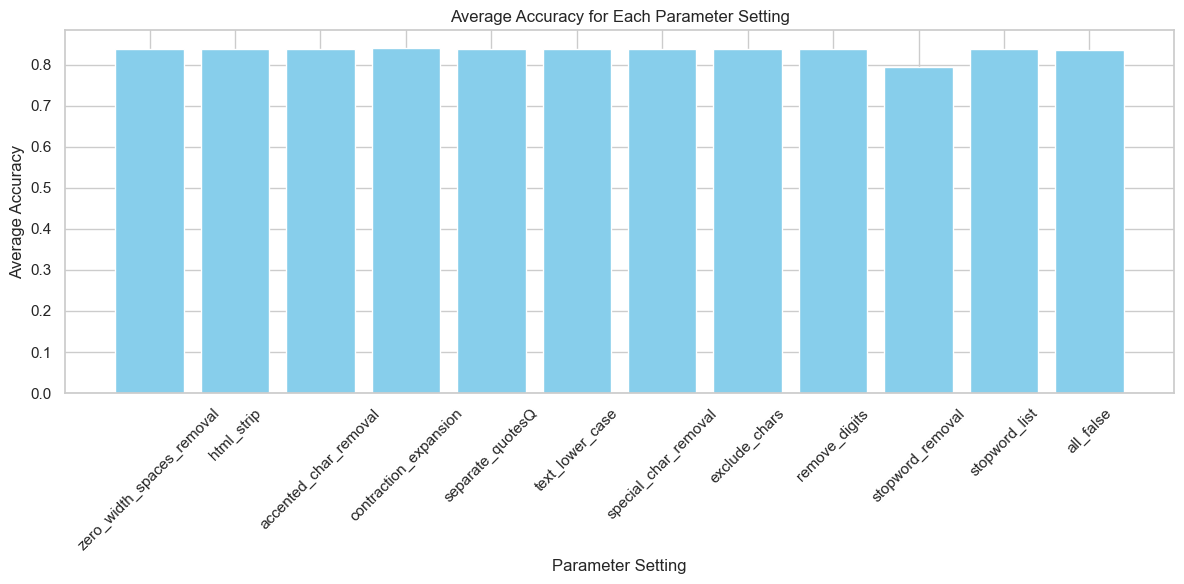

In [26]:
# Check the effects of every text normalization parameter on the model performance

import inspect

# Get the signature of the function
sig = inspect.signature(text_pre_processor)

# Get the keyword arguments (parameters with default values)
kwargs = {k: v.default for k, v in sig.parameters.items() if v.default is not inspect.Parameter.empty}

# Iterate over the keyword arguments
for arg, default in kwargs.items():
    print(f"{arg}: {default}")

all_false_kwargs = {k: False for k in kwargs}

# Ensure exclude_chars is set to its default string value, not False
all_false_kwargs['exclude_chars'] = kwargs['exclude_chars']
all_false_kwargs['text_lemmatization'] = False  # lemmatization is slow
all_false_kwargs['stopword_list'] = None  # stopword_list is None by default

av_accuracy = {} # average accuracy for each parameter setting

for arg, default in kwargs.items():
    
    # Skip the 'text_lemmatization' argument since it is slow
    if arg in ['text_lemmatization', 'stopword_list' 'exclude_chars']:
        print(f"{arg}: Skipped (slow)")
        continue
    print(f"{arg}: True")

    # Set all default kwargs, but override the current arg to True
    test_kwargs = all_false_kwargs.copy()
    test_kwargs[arg] = True

    norm_train = corpus_pre_processor(X_train, **test_kwargs)
    norm_test = corpus_pre_processor(X_test, **test_kwargs)

    # build TFIDF features on train
    ngram_range = (1, 1)  # unigrams and bigrams
    tv = TfidfVectorizer(use_idf=True, min_df=1, max_df=1.0, ngram_range=ngram_range,
                        sublinear_tf=True)
                        
    tv_train_features = tv.fit_transform(norm_train)
    tv_test_features = tv.transform(norm_test)

    # train a logistic regression model
    lr = LogisticRegression(penalty='l2', max_iter=5000, C=1,
                            solver='lbfgs', random_state=42)

    lr.fit(tv_train_features, y_train)

    # predict on test data
    lr_bow_predictions = lr.predict(tv_test_features)

    labels = ['negative', 'positive']
    print(f"{arg}: {classification_report(y_test, lr_bow_predictions)}")
    av_accuracy[arg] = lr.score(tv_test_features, y_test)

# All parameters set to False
norm_train = corpus_pre_processor(X_train, **all_false_kwargs)
norm_test = corpus_pre_processor(X_test, **all_false_kwargs)
# All parameters set to False
# Additional iteration: set all kwargs to False (except text_lemmatization)
all_false_kwargs = {k: False for k in kwargs}
all_false_kwargs['text_lemmatization'] = False  # lemmatization is slow

norm_train = corpus_pre_processor(X_train, **all_false_kwargs)
norm_test = corpus_pre_processor(X_test, **all_false_kwargs)

# build TFIDF features on train
tv = TfidfVectorizer(use_idf=True, min_df=5, max_df=1.0, ngram_range=ngram_range, sublinear_tf=True)
tv_train_features = tv.fit_transform(norm_train)
tv_test_features = tv.transform(norm_test)

# train a logistic regression model
lr = LogisticRegression(penalty='l2', max_iter=5000, C=1, solver='lbfgs', random_state=42)
lr.fit(tv_train_features, y_train)

# predict on test data
lr_bow_predictions = lr.predict(tv_test_features)

labels = ['negative', 'positive']
print('All kwargs set to False:')
print(classification_report(y_test, lr_bow_predictions))
av_accuracy['all_false'] = lr.score(tv_test_features, y_test)

# Plot the average accuracy for each parameter setting
plt.figure(figsize=(12, 6))
plt.bar(av_accuracy.keys(), av_accuracy.values(), color='skyblue')
plt.xlabel('Parameter Setting')
plt.ylabel('Average Accuracy')
plt.title('Average Accuracy for Each Parameter Setting')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
    

In [29]:
av_accuracy

{'zero_width_spaces_removal': 0.8389662027833003,
 'html_strip': 0.8389662027833003,
 'accented_char_removal': 0.8388492573967957,
 'contraction_expansion': 0.8413051105133903,
 'separate_quotesQ': 0.8389662027833003,
 'text_lower_case': 0.8389662027833003,
 'special_char_removal': 0.8390831481698047,
 'exclude_chars': 0.8389662027833003,
 'remove_digits': 0.8389662027833003,
 'stopword_removal': 0.7946439012980938,
 'stopword_list': 0.8389662027833003,
 'all_false': 0.8346392234826336}

## TFIDF and LR

In [122]:
X_ = corpus_pre_processor_1(X)

  0%|          | 0/28503 [00:00<?, ?it/s]/var/folders/qt/8nh0yrjj4q5dvgzzdm8s9j_40000gn/T/ipykernel_4246/3951685545.py:18: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
100%|██████████| 28503/28503 [00:00<00:00, 29823.25it/s]


### TFIDF before train-test split (experiment!)

* Use all vocabulary from the data to encode all sample
* Avoiding many cases new vocabulary on shown in the test set
* Only for experiment: but it does not improve the accuracy

#### Default tokenizer_pattern

In [ ]:
ngram_range = (1, 1)  # unigrams and bigrams

# Build TFIDF features on train
# Small max_df removal of common words; Removing common words decreases accuracy
# max_df = 0.2, removing a few 2 common words (acc=0.84)
# max_df = 0.15, removing 30 common words (acc=0.82)
# the removal of common words (in the data) by max_df is different from Stopword Removal based on the language
# the default 'token_pattern' in TfidfVectorizer excludes single-character tokens

tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0, ngram_range=ngram_range,
                     sublinear_tf=True,
                     #token_pattern=r'(?u)\b\w+\b'
                     )  # include single-character tokens

tv_X_features = tv.fit_transform(X_)
print('Why is it not the whole vocabulary? (38234)', 'Because of token_pattern')
print(tv_X_features.shape)

# Train-test split again
tv_train_features, tv_test_features, y_train, y_test = train_test_split(tv_X_features, y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)


# Logistic Regression model on BOW features
lr = LogisticRegression(penalty='l2', max_iter=5000, C=1, solver='lbfgs', random_state=42)
lr.fit(tv_train_features, y_train)
lr_bow_predictions = lr.predict(tv_test_features)

labels = ['negative', 'positive']
print(classification_report(y_test, lr_bow_predictions, digits=4))
pd.DataFrame(confusion_matrix(y_test, lr_bow_predictions), index=labels, columns=labels)

av_accuracy['utfTok_Tfid_ttSplit'] = lr.score(tv_test_features, y_test)


  0%|          | 0/28503 [00:00<?, ?it/s]/var/folders/qt/8nh0yrjj4q5dvgzzdm8s9j_40000gn/T/ipykernel_4246/3951685545.py:18: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
100%|██████████| 28503/28503 [00:00<00:00, 31064.24it/s]


Why is it not the whole vocabulary? (38234) Because of token_pattern
(28503, 26273)
              precision    recall  f1-score   support

           0     0.8557    0.8395    0.8475      4485
           1     0.8265    0.8438    0.8351      4066

    accuracy                         0.8415      8551
   macro avg     0.8411    0.8416    0.8413      8551
weighted avg     0.8418    0.8415    0.8416      8551



In [113]:
print(tv.get_feature_names_out()[:100])  # first 100 features
print(tv.get_feature_names_out()[-100:])  # last 100 features
print(tv.get_feature_names_out()[10000:10100])  # 1000-1020 features
print(tv.get_feature_names_out()[20000:20100])  # 20000-20020 features

['00' '000' '00000000001' '00003' '000th' '025' '03' '047' '071' '10'
 '100' '100th' '102' '103' '104' '105' '106' '107' '108' '109' '10th'
 '10ths' '11' '110' '1106' '112' '112th' '113' '113th' '114' '115' '116'
 '117' '11717' '118' '11th' '12' '120' '122' '125' '12th' '13' '130' '134'
 '135' '137' '138' '13th' '14' '140' '141' '142' '145' '146' '147' '149th'
 '14th' '15' '150' '155th' '156' '1580s' '159' '15s' '15th' '16' '160'
 '161' '163' '165' '16th' '17' '170' '172' '1743' '175' '1776' '17th' '18'
 '180' '1822' '1850' '186' '1861' '1893' '18th' '19' '1913' '1914' '1915'
 '1919' '1927' '1928' '193' '1930s' '1933' '1937' '1939' '194' '1940']
['youthful' 'youths' 'youtube' 'youtuber' 'yowling' 'yuan' 'yuletide'
 'yup' 'yutu' 'zaatari' 'zac' 'zach' 'zachary' 'zack' 'zaeefeh' 'zagat'
 'zagitova' 'zaire' 'zakaria' 'zales' 'zalman' 'zalmay' 'zambia' 'zamboni'
 'zandt' 'zangief' 'zanjeer' 'zany' 'zapp' 'zappa' 'zapper' 'zappos'
 'zara' 'zarin' 'zawahiri' 'zayn' 'zbt' 'zealand' 'zealot' '

#### Global vocabulary, split, Tfidf

In [ ]:
# X_ = corpus_pre_processor(X,
#                        zero_width_spaces_removal=True, html_strip=False,  non_english_removal=True, 
#                        placeholder='<FOREIGN>',
#                        accented_char_removal=True, contraction_expansion=True,
#                        text_lower_case=True, text_lemmatization=False,
#                        special_char_removal=False, exclude_chars='\'\"-{}<>', remove_digits=True, 
#                        stopword_removal=False,
#                        stopword_list=None)

#X_ = corpus_pre_processor_1(X)

  0%|          | 0/28503 [00:00<?, ?it/s]/var/folders/qt/8nh0yrjj4q5dvgzzdm8s9j_40000gn/T/ipykernel_4246/3951685545.py:18: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
100%|██████████| 28503/28503 [00:00<00:00, 31868.58it/s]


In [ ]:
# 1. Get all unique words from the normalized data
all_tokens = [word for doc in X_ for word in doc.split()]
unique_words = sorted(set(all_tokens))  # sorted for reproducibility
print(unique_words[-20:])  # print first 10 unique words for brevity
print(f"Total unique words: {len(unique_words)}")

# The raw vocabulary from X=df['headline'] contains some:
# '\u200bmocked', '\u200bmummies', '\u200breport:', '–', '—', '―', '“a', '“drain', '“many', '“the', '“war']
# \u200b is a zero-width space character, often used in text to create invisible spaces
# '-' different Unicode dash characters

# 2. Create a vocabulary dictionary for TfidfVectorizer
vocab_dict = {word: idx for idx, word in enumerate(unique_words)}

# 3. Create a TfidfVectorizer with the custom vocabulary
ngram_range = (1, 1)  # unigrams and bigrams

# 4. Train-test split again
norm_train, norm_test, y_train, y_test = train_test_split(X_, y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)

# build TFIDF features on train
tv = TfidfVectorizer(vocabulary=vocab_dict, 
                     use_idf=True, min_df=1, max_df=1.0, ngram_range=ngram_range,
                     sublinear_tf=True,
                     ) # ngram_range=(1, 2) not applied because of the vocabulary
                     
tv_train_features = tv.fit_transform(norm_train)
print(tv_train_features.shape)
tv_test_features = tv.transform(norm_test)


# Logistic Regression model on BOW features
# instantiate model
lr = LogisticRegression(penalty='l2', max_iter=5000, C=1,
                        solver='lbfgs', random_state=42)
# train model
lr.fit(tv_train_features, y_train)
# predict on test data
lr_bow_predictions = lr.predict(tv_test_features)

labels = ['negative', 'positive']
print(classification_report(y_test, lr_bow_predictions, digits=4))

av_accuracy['utfTok_gobVoc_ttSplit_Tfid'] = lr.score(tv_test_features, y_test)


['zoetrope', 'zogby', 'zohan', 'zombie', 'zone', 'zones', 'zoning', 'zoo', 'zookeeper', 'zoolander', 'zoologist', 'zoologists', 'zoomed', 'zoroastrianism', 'zsa', 'zucker', 'zuckerberg', 'zz', '{', '}']
Total unique words: 26385
(19952, 26385)
              precision    recall  f1-score   support

           0     0.8549    0.8395    0.8471      4485
           1     0.8264    0.8428    0.8345      4066

    accuracy                         0.8411      8551
   macro avg     0.8406    0.8412    0.8408      8551
weighted avg     0.8413    0.8411    0.8411      8551



In [134]:
print(tv.get_feature_names_out()[:100])  # first 100 features
print(tv.get_feature_names_out()[-100:])  # last 100 features
print(tv.get_feature_names_out()[10000:10100])  # 1000-1020 features
print(tv.get_feature_names_out()[20000:20100])  # 20000-20020 features

['!' '"' '#' '$' '%' '&' "'" '(' ')' '*@@' '*nsync' '*you*' '+' ',' '-'
 '.' '/' '0' '00' '000' '00000000001' '00003' '000th' '025' '03' '047'
 '071' '1' '1/2' '1/5' '10' '100' '100th' '102' '103' '104' '105' '106'
 '107' '108' '109' '10th' '11' '110' '1106' '112' '112th' '113' '113th'
 '114' '115' '116' '117' '11717' '118' '11th' '12' '12/20' '120' '122'
 '125' '12th' '13' '130' '134' '135' '137' '138' '13th' '14' '140' '141'
 '142' '145' '146' '147' '149th' '14th' '15' '150' '155th' '156' '1580s'
 '159' '15s' '15th' '16' '160' '161' '163' '165' '16th' '17' '170' '172'
 '1743' '175' '1776' '17th' '18']
['youtuber' 'yowling' 'yuan' 'yuletide' 'yup' 'yutu' 'z' 'zaatari' 'zac'
 'zach' 'zachary' 'zack' 'zaeefeh' 'zagat' 'zagitova' 'zaire' 'zakaria'
 'zales' 'zalman' 'zalmay' 'zambia' 'zamboni' 'zandt' 'zangief' 'zanjeer'
 'zany' 'zapp' 'zappa' 'zapper' 'zappos' 'zara' 'zarin' 'zawahiri' 'zayn'
 'zbt' 'zealand' 'zealot' 'zebra' 'zebras' 'zedd' 'zee' 'zeev' 'zehnder'
 'zeke' 'zell' 'zellweg

In [135]:
# build TFIDF features on train
tv = TfidfVectorizer(#vocabulary=vocab_dict, 
                     use_idf=True, min_df=1, max_df=1.0, ngram_range=ngram_range,
                     sublinear_tf=True,
                     analyzer='word',
                     token_pattern=r'(?u)\b\w+\b' # without voc with this pattern, acc.= 0.8479
                     ) # ngram_range=(1, 2) not applied because of the vocabulary
                     
tv_train_features = tv.fit_transform(norm_train)
print(tv_train_features.shape)
tv_test_features = tv.transform(norm_test)

# Logistic Regression model on BOW features
# instantiate model
lr = LogisticRegression(penalty='l2', max_iter=5000, C=1,
                        solver='lbfgs', random_state=42)
# train model
lr.fit(tv_train_features, y_train)
# predict on test data
lr_bow_predictions = lr.predict(tv_test_features)

labels = ['negative', 'positive']
print(classification_report(y_test, lr_bow_predictions, digits=4))

(19952, 22437)
              precision    recall  f1-score   support

           0     0.8599    0.8482    0.8540      4485
           1     0.8350    0.8475    0.8412      4066

    accuracy                         0.8479      8551
   macro avg     0.8474    0.8478    0.8476      8551
weighted avg     0.8480    0.8479    0.8479      8551



In [136]:
print(tv.get_feature_names_out()[:100])  # first 100 features
print(tv.get_feature_names_out()[-100:])  # last 100 features
print(tv.get_feature_names_out()[10000:10100])  # 1000-1020 features
print(tv.get_feature_names_out()[20000:20100])  # 20000-20020 features

['0' '00' '000' '00003' '000th' '03' '047' '071' '1' '10' '100' '100th'
 '102' '103' '104' '105' '107' '109' '10th' '11' '112' '112th' '113'
 '113th' '114' '115' '116' '117' '11717' '118' '11th' '12' '120' '122'
 '125' '12th' '13' '130' '135' '137' '13th' '14' '140' '141' '145' '146'
 '147' '14th' '15' '150' '155th' '156' '159' '15th' '16' '160' '161' '163'
 '165' '16th' '17' '170' '1743' '175' '17th' '18' '180' '1822' '1850'
 '186' '1861' '1893' '18th' '19' '1913' '1914' '1915' '1919' '1927' '1928'
 '1930s' '1937' '1939' '194' '1940' '1940s' '1945' '1948' '1950s' '1960s'
 '1964' '1967' '1969' '1970' '1972' '1980' '1980s' '1981' '1982' '1983']
['yoko' 'yolk' 'yolo' 'yom' 'yordano' 'yore' 'york' 'yorke' 'yorker'
 'yorkers' 'yorkshire' 'yosemite' 'yoshi' 'yothers' 'you' 'young'
 'younger' 'youngest' 'your' 'yours' 'yourself' 'yourselves' 'youssef'
 'youth' 'youths' 'youtube' 'youtuber' 'yuan' 'yuletide' 'yup' 'z'
 'zaatari' 'zac' 'zachary' 'zagitova' 'zales' 'zalmay' 'zamboni' 'zandt'
 '

In [126]:
for i in np.random.randint(0, len(X_), size=5):
    print(f"Original: {X.iloc[i]}")
    print(f"Processed: {X_[i]}")
    print()

Original: winchester unveils new 9mm stray bullet guaranteed to hit innocent bystanders
Processed: winchester unveils new 9mm stray bullet guaranteed to hit innocent bystanders

Original: lemur fantasizes about ripping face off next dumbshit who calls it a monkey
Processed: lemur fantasizes about ripping face off next dumbshit who calls it a monkey

Original: voters in 14 states navigating new rules while trying to cast ballots
Processed: voters in 14 states navigating new rules while trying to cast ballots

Original: bts just became the first k-pop band to go gold
Processed: bts just became the first k - pop band to go gold

Original: are you the artist...or the masterpiece?
Processed: are you the artist . . . or the masterpiece ?



### Train-test split before TFIDF

#### Default token_pattern

In [138]:
norm_train, norm_test, y_train, y_test = train_test_split(X_, y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)

In [ ]:
%%time
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

ngram_range = (1, 1)  # unigrams and bigrams

# build TFIDF features on train
tv = TfidfVectorizer(use_idf=True, min_df=1, max_df=1.0, ngram_range=ngram_range,
                     sublinear_tf=True)
                     
tv_train_features = tv.fit_transform(norm_train)
print(tv_train_features.shape)

# transform test reviews into features
# we use .transform(..) and NOT .fit_transform(..)
# to use vocabulary learnt during training data as our features
tv_test_features = tv.transform(norm_test)

lr = LogisticRegression(penalty='l2', max_iter=5000, C=1,
                        solver='lbfgs', random_state=42)

lr.fit(tv_train_features, y_train)
lr_bow_predictions = lr.predict(tv_test_features)

labels = ['negative', 'positive']
print(classification_report(y_test, lr_bow_predictions, digits=4))
pd.DataFrame(confusion_matrix(y_test, lr_bow_predictions), index=labels, columns=labels)

av_accuracy['utfTok_ttSplit_Tfidf'] = lr.score(tv_test_features, y_test)

(19952, 22401)
              precision    recall  f1-score   support

           0     0.8539    0.8404    0.8471      4485
           1     0.8269    0.8414    0.8341      4066

    accuracy                         0.8408      8551
   macro avg     0.8404    0.8409    0.8406      8551
weighted avg     0.8411    0.8408    0.8409      8551

CPU times: user 804 ms, sys: 33.9 ms, total: 838 ms
Wall time: 271 ms


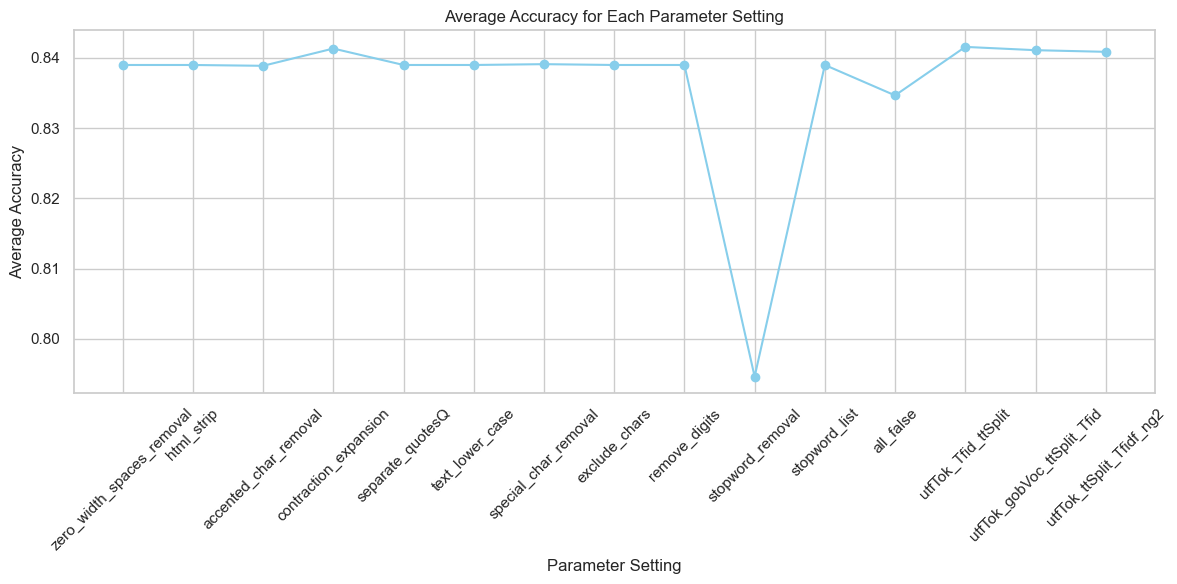

In [141]:
# Plot the average accuracy for each parameter setting
plt.figure(figsize=(12, 6))
plt.plot(av_accuracy.keys(), av_accuracy.values(), color='skyblue', marker='o')
plt.xlabel('Parameter Setting')
plt.ylabel('Average Accuracy')
plt.title('Average Accuracy for Each Parameter Setting')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
    

## Fine tuning

In [ ]:
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import GridSearchCV

# # Define the pipeline
# pipeline = Pipeline([
#     ('vectorizer', TfidfVectorizer(use_idf=True, sublinear_tf=True)),
#     ('classifier', LogisticRegression(random_state=42))
# ])

# # Define the parameter grid for both vectorizer and classifier
# param_grid = {
#     'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
#     'vectorizer__min_df': [1, 5],
#     'vectorizer__max_df': [0.5, 1.0],
#     'classifier__C': [0.1, 1, 10],
#     'classifier__penalty': ['l1', 'l2'],
#     'classifier__solver': ['liblinear', 'saga'],
#     'classifier__max_iter': [1000, 5000]
# }

# # Instantiate the GridSearchCV object
# grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, n_jobs=-1,
#                            scoring='accuracy', verbose=1)

# # Fit the model on normalized text, not pre-vectorized features
# grid_search.fit(norm_train, y_train)

# # Get the best parameters and score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_
# print(f"Best parameters: {best_params}")
# print(f"Best cross-validation score: {best_score:.4f}")

# # Predict on the test set with the best model
# best_model = grid_search.best_estimator_
# lr_bow_predictions = best_model.predict(norm_test)
# labels = ['negative', 'positive']
# print(classification_report(y_test, lr_bow_predictions))
# print(pd.DataFrame(confusion_matrix(y_test, lr_bow_predictions), index=labels, columns=labels))

# FastText Embedding for LR

* Text normalization not helping!

## Embedding raw and normalized data

In [150]:
from gensim.models import FastText
from gensim.utils import simple_preprocess, tokenize

# Tokenize the documents for FastText
# tokenized_docs = [simple_preprocess(doc) for doc in norm_corpus]

# Different from simple_preprocess, tokenize does not remove punctuation and lowercases the text
# but we have already preprocessed the corpus, so we can use a simple split for tokenization
# Note: simple_preprocess is more suitable for raw text, while tokenize is more suitable for preprocessed text.

tokenized_train = [doc.split() for doc in X_train] # Using split to tokenize by whitespace; norm_corpus is already preprocessed

# ideal config params size: 300, window: 30, min_count=2 or more, iter=50 or more (use 10 if it takes too much time)
ft_model_raw = FastText(sentences=tokenized_train, vector_size=300, window=5, min_count=2, epochs=50, sg=1)

In [ ]:
from gensim.models import FastText
from gensim.utils import simple_preprocess, tokenize

tokenized_train = [doc.split() for doc in norm_train]
ft_model_norm = FastText(sentences=tokenized_train, vector_size=300, window=5, min_count=2, epochs=50, sg=1)

## Averaged word2vec and LR for raw and normalized

In [ ]:
import numpy as np

def averaged_word2vec_vectorizer(corpus, model, num_features):
    # Initialize an empty list to hold the feature vectors
    features = []
    # Iterate through each document in the corpus
    for doc in corpus:
        # Tokenize the document
        tokens = doc.split()
        # Initialize a zero vector for the document
        feature_vector = np.zeros((num_features,), dtype='float32')
        n_words = 0
        # Iterate through each token in the document
        for token in tokens:
            # If the token is in the model's vocabulary, add its vector to the feature vector
            if token in model.wv:
                feature_vector = np.add(feature_vector, model.wv[token])
                n_words += 1
        # If no words were found in the model's vocabulary, append a zero vector
        if n_words == 0:
            features.append(np.zeros((num_features,), dtype='float32'))
        else:
            # Otherwise, average the feature vector by the number of words
            feature_vector = np.divide(feature_vector, n_words)
            features.append(feature_vector)
    # Convert the list of feature vectors to a NumPy array
    features = np.array(features)
    # Return the array of feature vectors
    return np.array(features)

In [ ]:
# Using embedding vectors based on raw training data
# Note: The model is trained on the raw training data, not the preprocessed one

vecs_ft_train = averaged_word2vec_vectorizer(corpus=norm_train, model=ft_model_raw, num_features=300)
vecs_ft_test = averaged_word2vec_vectorizer(corpus=norm_test, model=ft_model_raw, num_features=300)

# Logistic Regression model on FastText features
lr_ft = LogisticRegression(random_state=42)
lr_ft.fit(vecs_ft_train, y_train)

# Predict on the test set
lr_ft_predictions = lr_ft.predict(vecs_ft_test)

print(classification_report(y_test, lr_ft_predictions, digits=4))
print(pd.DataFrame(confusion_matrix(y_test, lr_ft_predictions), index=labels, columns=labels))

# The raw vocabulary from X=df['headline']

              precision    recall  f1-score   support

           0     0.8326    0.8453    0.8389      4485
           1     0.8264    0.8126    0.8194      4066

    accuracy                         0.8297      8551
   macro avg     0.8295    0.8289    0.8292      8551
weighted avg     0.8297    0.8297    0.8297      8551

          negative  positive
negative      3791       694
positive       762      3304


In [ ]:
# Using embedding vectors based on normalized training data
# Note: The model is trained on the normalized training data, not the raw one

vecs_ft_train = averaged_word2vec_vectorizer(corpus=norm_train, model=ft_model_norm, num_features=300)
vecs_ft_test = averaged_word2vec_vectorizer(corpus=norm_test, model=ft_model_norm, num_features=300)

# Logistic Regression model on FastText features
lr_ft = LogisticRegression(random_state=42)
lr_ft.fit(vecs_ft_train, y_train)

# Predict on the test set
lr_ft_predictions = lr_ft.predict(vecs_ft_test)

print(classification_report(y_test, lr_ft_predictions, digits=4))
print(pd.DataFrame(confusion_matrix(y_test, lr_ft_predictions), index=labels, columns=labels))

# The raw vocabulary from X=df['headline']

              precision    recall  f1-score   support

           0     0.8339    0.8386    0.8362      4485
           1     0.8208    0.8158    0.8183      4066

    accuracy                         0.8277      8551
   macro avg     0.8274    0.8272    0.8273      8551
weighted avg     0.8277    0.8277    0.8277      8551

          negative  positive
negative      3761       724
positive       749      3317


# Deep learning with learning embeddings

## Check unique words

In [166]:
words_train = [word for doc in X_train for word in doc.split()]
unique_words_train = set(words_train)
print(f"Number of unique words in the training vocabulary: {len(unique_words_train)}")

words_test = [word for doc in X_test for word in doc.split()]
unique_words_test = set(words_test)
print(f"Number of unique words in the test vocabulary: {len(unique_words_test)}")


# Combine unique words from both train and test sets
unique_words = unique_words_train.union(unique_words_test)
print(f"Number of unique words in the vocabulary: {len(unique_words)}")

# Unique words in test but not in train
unique_words_in_test_not_in_train = unique_words_test - unique_words_train
print(f"Number of unique words in test but not in train: {len(unique_words_in_test_not_in_train)}")
print(f"Unique words in test but not in train: {list(unique_words_in_test_not_in_train)[:20]}")  # Display first 20 unique words


Number of unique words in the training vocabulary: 31121
Number of unique words in the test vocabulary: 19082
Number of unique words in the vocabulary: 38234
Number of unique words in test but not in train: 7113
Unique words in test but not in train: ['zipping', "hallburton's", "bears'", '4-beer', 'shaky,', 'trump/netanyahu', 'antidote', 'tiebreaker', 'optimists', 'theirs', "'dallas", 'prowling', "'sad,'", 'profusely', 'pedicure', 'instructors', 'disrupting', "'clown", 'slaw', 'oscar-night']


## Sentence length distribution

Number of unique words in the vocabulary: 38234


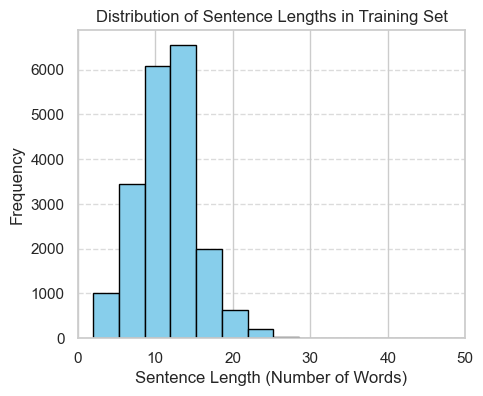

In [ ]:
# Number of unique words in the vocabulary
tokens = [word for doc in X for word in doc.split()]
unique_words = set(tokens)
print(f"Number of unique words in the vocabulary: {len(unique_words)}")

# Plot the distribution of sentence lengths
sentence_lengths = [len(doc.split()) for doc in norm_train]
plt.figure(figsize=(5, 4))
plt.hist(sentence_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Sentence Lengths in Training Set')
plt.xlabel('Sentence Length (Number of Words)')
plt.ylabel('Frequency')
plt.xlim(0, 50)  # Limit x-axis to 50 words for better visibility
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## RNN

In [167]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping

In [168]:
# train test split
X_train_norm, X_test_norm, y_train, y_test = train_test_split(X_, y, test_size=0.3, random_state=42, stratify=y)

In [170]:
# Tokenization
MAX_VOCAB_SIZE = 29000
MAX_SEQUENCE_LENGTH = 20

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=None, # Set to None to include all unique words
    oov_token="<UNK>",
    filters=''
)
tokenizer.fit_on_texts(X_train_norm)

# Convert to sequences and pad
X_train_features = tf.keras.utils.pad_sequences(
    tokenizer.texts_to_sequences(X_train_norm), maxlen=MAX_SEQUENCE_LENGTH
)
X_test_features = tf.keras.utils.pad_sequences(
    tokenizer.texts_to_sequences(X_test_norm), maxlen=MAX_SEQUENCE_LENGTH
)

# Calculate vocab_size based on the full vocabulary in word_index
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")
print(f"Sequence length: {len(X_train_norm)}") # Changed .shape to len()

Vocabulary size: 22498
Sequence length: 19952


!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

In [ ]:
# Pre-trained Embeddings from GloVe
import numpy as np
from gensim.models import KeyedVectors

# Load pre-trained GloVe embeddings
glove_file = 'glove.6B.300d.txt'  # Path to the GloVe file
glove_model = KeyedVectors.load_word2vec_format(glove_file, binary=False, no_header=True)

def create_bi_gru_model_with_glove_embeddings(embedding_matrix):
    """Bidirectional GRU model with pre-trained GloVe embeddings"""
    model = keras.models.Sequential(
        [
            keras.layers.Embedding(
                input_dim=embedding_matrix.shape[0],
                output_dim=embedding_matrix.shape[1],
                weights=[embedding_matrix],
                trainable=False,  # Set to True if you want to fine-tune the embeddings
            ),
            keras.layers.Bidirectional(keras.layers.GRU(64)),
            keras.layers.Dense(64, activation="relu"),
            keras.layers.Dense(1, activation="sigmoid"),
        ],
        name="BiGRU_with_GloVe",
    )

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    return model

# Create the embedding matrix
def create_embedding_matrix(word_index, embedding_model):
    embedding_dim = embedding_model.vector_size
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    
    for word, i in word_index.items():
        if word in embedding_model:
            embedding_matrix[i] = embedding_model[word]
    
    return embedding_matrix

# Create the embedding matrix using the GloVe model
embedding_matrix = create_embedding_matrix(tokenizer.word_index, glove_model)

# Create the Bi-GRU model with GloVe embeddings
bi_gru_model = create_bi_gru_model_with_glove_embeddings(embedding_matrix)

# Train the Bi-GRU model with GloVe embeddings
bi_gru_history = bi_gru_model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
)

# Evaluate the Bi-GRU model with GloVe embeddings
bi_gru_test_loss, bi_gru_test_accuracy = bi_gru_model.evaluate(X_test, y_test, verbose=0)
print(f"Bi-GRU Test Loss: {bi_gru_test_loss:.4f}")
print(f"Bi-GRU Test Accuracy: {bi_gru_test_accuracy:.4f}")


In [ ]:
# Pre-trained Embeddings
# Bi-GRU with pretrained embeddings
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, GRU, Dense, Dropout

def create_bi_gru_model():
    """Bidirectional GRU model"""
    model = Sequential()
    model.add(Embedding(vocab_size, EMBEDDING_DIM))
    model.add(Bidirectional(GRU(64)))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# Instantiate the model
bi_gru_model = create_bi_gru_model()    

In [ ]:
# Bi-GRU with pretrained embeddings

EMBEDDING_DIM = 2
EPOCHS = 5
BATCH_SIZE = 1024

def create_bi_gru_model():
    """Bidirectional GRU model"""
    model = keras.models.Sequential(
        [
            keras.layers.Embedding(vocab_size, EMBEDDING_DIM),
            keras.layers.Bidirectional(keras.layers.GRU(64)),
            keras.layers.Dense(64, activation="relu"),
            keras.layers.Dense(1, activation="sigmoid"),
        ],
        name="BiGRU",
    )

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model
# Train Bi-GRU model
bi_gru_model = create_bi_gru_model()
bi_gru_history = bi_gru_model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
)

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification

# 1. load data ===
# Sample placeholder — replace with your actual data
headlines = X  # List of 28k text headlines
labels = y     # List of 28k binary labels (0 or 1)

# Convert to numpy arrays
headlines = np.array(headlines)
labels = np.array(labels)

# 2. Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(
    headlines, labels, test_size=0.3, random_state=42, stratify=labels
)

# 3. Tokenization
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)

# Tokenize inputs
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, return_tensors="tf")
val_encodings = tokenizer(list(X_val), truncation=True, padding=True, return_tensors="tf")

# 4. Convert to TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
)).shuffle(1000).batch(32)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val
)).batch(32)

# 5. Load Pretrained BERT for Classification
model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# 6. Compile the Model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5) # Use tf.keras.optimizers.Adam

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# 7. Train the Model
early_stop = EarlyStopping(monitor="val_accuracy", patience=2, restore_best_weights=True)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=4,
    callbacks=[early_stop]
)

# 8. Evaluate Model
val_preds = model.predict(val_dataset).logits
y_pred = np.argmax(val_preds, axis=1)
print("\nClassification Report:\n")
print(classification_report(y_val, y_pred))

# Conclusion

This project shows that for short texts such as headlines, a well‑tuned TF‑IDF representation with a Logistic Regression classifier is a strong and efficient baseline. More advanced approaches — FastText embeddings, BiGRU sequence models, and fine‑tuned Transformers — provide alternative trade‑offs: better handling of rare or subword patterns, contextual understanding, and potentially higher accuracy at the cost of compute and complexity.

Key takeaways:
- Text normalization needs to be chosen carefully: aggressive stopword removal decreased accuracy in our experiments, while targeted normalization (contraction expansion, hyphen unification, zero-width space removal) helped.
- Use TF‑IDF + LR as a fast baseline. Only add complexity when you need semantic/contextual understanding that TF‑IDF cannot capture.
- For production: add deterministic preprocessing, model versioning, saving/loading of artifacts, unit tests on preprocessing, and a model card describing dataset provenance and limitations.